Понизить размерность данных BRCA_pam50.tsv до𝑑= 2двумяспособами: с помощью метода главных компонент и t-SNE.Применить к полученным данным метод𝑘ближайших соседей(выбрав оптимальные параметры с помощью кросс-валидации).Сравнить качество классификации двух моделей.

In [85]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv('https://raw.githubusercontent.com/s-a-nersisyan/HSE_bioinformatics_2021/master/seminar15/BRCA_pam50.tsv', index_col = 0, sep = '\t')

In [82]:
df.head()

,UBE2T,BIRC5,NUF2,CDC6,CCNB1,TYMS,MYBL2,CEP55,MELK,NDC80,...,GPR160,FGFR4,GRB7,TMEM45B,ERBB2,Subtype,pca_1,pca_2,tsne_1,tsne_2
TCGA-A1-A0SB-01A,2.507502,2.172270,0.952906,1.683162,3.108067,3.332448,2.982268,1.613604,1.641565,1.218495,...,1.141875,0.544443,2.942855,0.875017,5.014075,Normal-like,12.875404,-2.287930,-2.160388,-35.343548
TCGA-A1-A0SD-01A,3.016158,2.514871,1.509129,1.354016,3.685035,2.125453,3.047474,2.333704,1.996853,1.171520,...,3.942169,3.404177,3.655783,2.757977,5.999041,Luminal A,1.174805,-4.216140,-9.029854,-7.595053
TCGA-A1-A0SE-01A,4.626989,3.289047,2.102190,2.116975,4.525954,2.906470,3.798966,2.745027,2.451070,2.070499,...,3.881691,1.038253,3.156081,1.355837,5.585759,Luminal A,1.452293,-1.568554,-3.690228,-5.502025
TCGA-A1-A0SF-01A,3.417782,2.262844,1.569301,1.800667,3.823694,2.843952,3.807282,2.141323,2.082400,1.693568,...,4.374803,2.299735,3.054917,1.315680,5.215699,Luminal A,1.341335,-3.908965,-6.832485,-8.975402
TCGA-A1-A0SG-01A,2.948244,2.298689,1.116282,1.552142,3.582144,2.886328,2.697313,1.968233,1.662241,1.280947,...,3.381032,3.586285,2.845107,3.359571,5.786065,Luminal A,-2.855003,-4.028563,-10.115000,3.058416


In [60]:
model_pca, model_tsne = PCA(n_components = 2), TSNE()
df[['pca_1', 'pca_2']] = model.fit_transform(df.iloc[:, :-1])[:, :2]
df[['tsne_1', 'tsne_2']] = model_tsne.fit_transform(df.iloc[:, :50])

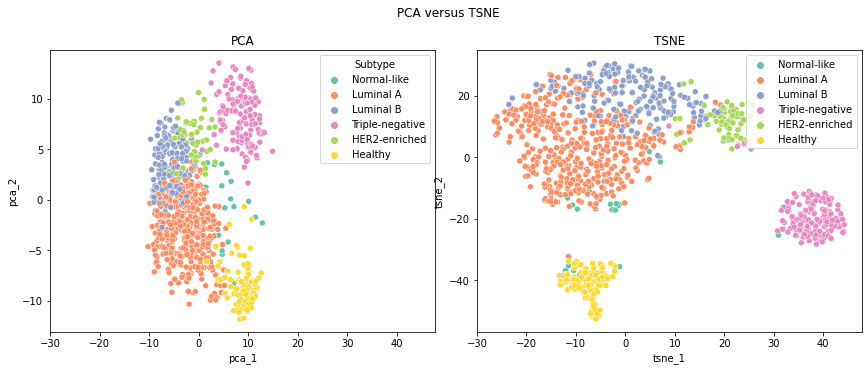

In [74]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
fig.suptitle('PCA versus TSNE')
axes[0].set_title('PCA')
axes[1].set_title('TSNE')

plt.tight_layout()

sns.scatterplot(ax=axes[0], data=df,x='pca_1', y='pca_2', hue='Subtype', palette='Set2')
sns.scatterplot(ax=axes[1], data=df, x='tsne_1', y='tsne_2', hue='Subtype', palette='Set2')

plt.legend(loc='upper right')


In [90]:
def best_params(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 17)
        
    model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',KNeighborsClassifier(n_neighbors=5, weights='distance', p=1))
])    
    
    model.fit(X_train, y_train)
    
    accuracy = cross_val_score(
    model, X, y,
    scoring=make_scorer(accuracy_score),
    cv=RepeatedStratifiedKFold(n_repeats=100)
    )
        
    params = {
        'clf__n_neighbors': [1,3,5,7,9, 10],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1,2]
    }

    
    cv = GridSearchCV(
        model, params,
        scoring = make_scorer(accuracy_score),
        cv = RepeatedStratifiedKFold(n_repeats=100)
    )

    cv.fit(X, y)
    return cv.best_params_, cv.best_score_

In [91]:
best_params(df[['pca_1', 'pca_2']].to_numpy(), df['Subtype'])

({'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'},
 0.8537595628415301)

In [92]:
best_params(df[['tsne_1', 'tsne_2']].to_numpy(), df['Subtype'])

({'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'},
 0.8849945355191257)